In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Cargar datos
df = pd.read_csv("base_fake.csv")
df.columns = df.columns.str.strip()
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["Mes"] = df["Fecha"].dt.month
df["Año"] = df["Fecha"].dt.year

# Variables
X = pd.get_dummies(df[["Semana", "Mes", "Año", "Cultivo", "Zona de Produccion"]], drop_first=True)
y = df["Litros_usados"]

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluación
print("R² Score:", r2_score(y_test, model.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, model.predict(X_test), squared=False))

R² Score: 0.849002548480934
RMSE: 11.357725926389325


In [3]:
# Crear fechas futuras
productores_unicos = df[["Productor", "Cultivo", "Zona de Produccion"]].drop_duplicates()
future_weeks = pd.date_range(start="2025-01-01", periods=50, freq="W")

pred_rows = []
for _, row in productores_unicos.iterrows():
    for i, fecha in enumerate(future_weeks, start=1):
        pred_rows.append({
            "Productor": row["Productor"],
            "Cultivo": row["Cultivo"],
            "Zona de Produccion": row["Zona de Produccion"],
            "Semana": i,
            "Mes": fecha.month,
            "Año": fecha.year,
            "Fecha": fecha
        })

df_pred = pd.DataFrame(pred_rows)

# Codificación y predicción
df_pred_encoded = pd.get_dummies(df_pred[["Semana", "Mes", "Año", "Cultivo", "Zona de Produccion"]], drop_first=True)
df_pred_encoded = df_pred_encoded.reindex(columns=X.columns, fill_value=0)
df_pred["Litros_estimado"] = model.predict(df_pred_encoded)

# Simulación de clima
np.random.seed(42)
df_clima = pd.DataFrame({
    "Fecha": pd.date_range(start="2025-01-01", end="2025-12-31", freq="D"),
    "Temperatura": np.random.normal(18, 3, 365),
    "Precipitacion": np.random.exponential(0.5, 365)
})
df_clima["Semana"] = df_clima["Fecha"].dt.isocalendar().week
df_clima["Año"] = df_clima["Fecha"].dt.year

df_clima_semanal = df_clima.groupby(["Año", "Semana"]).agg({
    "Temperatura": "mean",
    "Precipitacion": "sum"
}).reset_index()

df_clima_semanal["Necesidad_Litros_Ha_semana"] = (
    50 + df_clima_semanal["Temperatura"] * 10 - df_clima_semanal["Precipitacion"] * 5
).clip(lower=50, upper=300)

# Unir con predicciones
df_final = df_pred.merge(df_clima_semanal, on=["Año", "Semana"], how="left")
df_final["Diferencia_vs_clima"] = df_final["Litros_estimado"] - df_final["Necesidad_Litros_Ha_semana"]
df_final["Rendimiento_vs_clima"] = df_final["Diferencia_vs_clima"].apply(
    lambda x: "Ahorro" if x < -30 else "Sobreconsumo" if x > 30 else "Adecuado"
)

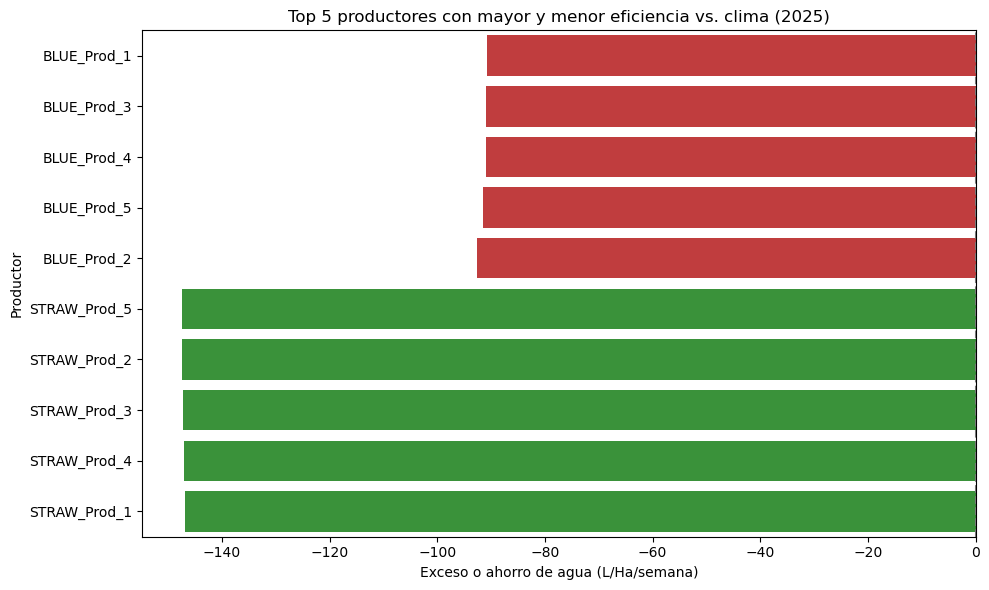

✅ Mapa generado como 'mapa_productores_consumo_2025.html'


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Gráfico barras top 5 sobre y sub consumo
resumen = df_final.groupby("Productor")[["Litros_estimado", "Necesidad_Litros_Ha_semana", "Diferencia_vs_clima"]].mean().round(1)
resumen = resumen.rename(columns={
    "Litros_estimado": "Consumo promedio L/Ha",
    "Necesidad_Litros_Ha_semana": "Necesidad climática L/Ha",
    "Diferencia_vs_clima": "Exceso o ahorro"
})
top_5_sobre = resumen.sort_values("Exceso o ahorro", ascending=False).head(5)
top_5_sub = resumen.sort_values("Exceso o ahorro").head(5)
resumen_grafico = pd.concat([top_5_sobre, top_5_sub])
resumen_grafico["Color"] = ["#d62728"] * 5 + ["#2ca02c"] * 5

plt.figure(figsize=(10, 6))
sns.barplot(
    data=resumen_grafico.reset_index(),
    x="Exceso o ahorro",
    y="Productor",
    palette=resumen_grafico["Color"]
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 5 productores con mayor y menor eficiencia vs. clima (2025)")
plt.xlabel("Exceso o ahorro de agua (L/Ha/semana)")
plt.ylabel("Productor")
plt.tight_layout()
plt.show()

# Mapa interactivo
zona_coords = {
    "Tuxcueca": (20.2, -103.4),
    "Guzmán": (19.7, -103.5),
    "Zamora": (19.98, -102.28),
    "Jocotepec": (20.28, -103.43),
    "Tangancícuaro": (19.88, -102.22)
}

map_data = df_final.groupby(["Productor", "Zona de Produccion"])[["Litros_estimado", "Diferencia_vs_clima"]].mean().reset_index()
m = folium.Map(location=[20.2, -103.3], zoom_start=7)

for _, row in map_data.iterrows():
    zona = row["Zona de Produccion"]
    productor = row["Productor"]
    litros = row["Litros_estimado"]
    diff = row["Diferencia_vs_clima"]
    lat, lon = zona_coords.get(zona, (20.0, -103.0))
    color = "green" if diff < -30 else "red" if diff > 30 else "blue"

    folium.CircleMarker(
        location=(lat, lon),
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{productor} ({zona})<br>Consumo: {litros:.1f} L/Ha<br>Diferencia: {diff:.1f}"
    ).add_to(m)

m.save("mapa_productores_consumo_2025.html")
print("✅ Mapa generado como 'mapa_productores_consumo_2025.html'")

In [5]:
import folium

# Coordenadas de zonas (puedes ajustar si lo necesitas)
zona_coords = {
    "Tuxcueca": (20.2, -103.4),
    "Guzmán": (19.7, -103.5),
    "Zamora": (19.98, -102.28),
    "Jocotepec": (20.28, -103.43),
    "Tangancícuaro": (19.88, -102.22)
}

# Promedios por productor y zona
map_data = df_final.groupby(["Productor", "Zona de Produccion"])[["Litros_estimado", "Diferencia_vs_clima"]].mean().reset_index()

# Crear mapa base
m = folium.Map(location=[20.2, -103.3], zoom_start=7)

# Añadir marcadores
for _, row in map_data.iterrows():
    zona = row["Zona de Produccion"]
    productor = row["Productor"]
    litros = row["Litros_estimado"]
    diff = row["Diferencia_vs_clima"]
    lat, lon = zona_coords.get(zona, (20.0, -103.0))
    color = "green" if diff < -30 else "red" if diff > 30 else "blue"

    folium.CircleMarker(
        location=(lat, lon),
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.75,
        popup=folium.Popup(
            f"<b>{productor}</b><br>Zona: {zona}<br><b>Consumo</b>: {litros:.1f} L/Ha<br><b>Diferencia</b>: {diff:.1f} L",
            max_width=250
        )
    ).add_to(m)

# Guardar
m.save("mapa_productores_2025.html")
print("✅ Nuevo mapa generado como 'mapa_productores_2025.html'")

✅ Nuevo mapa generado como 'mapa_productores_2025.html'


In [6]:
import plotly.express as px

# Asegurarnos que todo está en el formato correcto
df_final["Semana"] = df_final["Semana"].astype(int)

# Agrupar por semana y productor para visualizar consumo y necesidad
df_plot = df_final.groupby(["Semana", "Productor"]).agg({
    "Litros_estimado": "mean",
    "Necesidad_Litros_Ha_semana": "mean"
}).reset_index()

# Melt para hacer comparativo en la misma gráfica
df_melted = df_plot.melt(id_vars=["Semana", "Productor"], 
                         value_vars=["Litros_estimado", "Necesidad_Litros_Ha_semana"],
                         var_name="Tipo", value_name="Litros")

# Gráfico interactivo
fig = px.line(df_melted, 
              x="Semana", 
              y="Litros", 
              color="Tipo", 
              line_dash="Tipo",
              facet_col="Productor", 
              facet_col_wrap=3,
              title="📈 Comparación semanal de consumo vs necesidad climática (L/Ha)",
              labels={"Litros": "Litros por Ha", "Semana": "Semana del año"})

fig.update_layout(height=800)
fig.write_html("comparacion_semanal_productores.html")

print("✅ Gráfico interactivo generado como 'comparacion_semanal_productores.html'")

✅ Gráfico interactivo generado como 'comparacion_semanal_productores.html'


In [7]:
import folium
import branca.colormap as cm

# Agrupar consumo promedio por zona y cultivo
eficiencia = df_final.groupby(["Zona de Produccion", "Cultivo"])["Litros_estimado"].mean().reset_index()

# Coordenadas por zona
zona_coords = {
    "Tuxcueca": (20.2, -103.4),
    "Guzmán": (19.7, -103.5),
    "Zamora": (19.98, -102.28),
    "Jocotepec": (20.28, -103.43),
    "Tangancícuaro": (19.88, -102.22)
}

eficiencia["Latitud"] = eficiencia["Zona de Produccion"].map(lambda z: zona_coords[z][0])
eficiencia["Longitud"] = eficiencia["Zona de Produccion"].map(lambda z: zona_coords[z][1])

# Crear mapa
m = folium.Map(location=[20.1, -103.3], zoom_start=7)

# Colormap corregido
colormap = cm.LinearColormap(
    colors=["green", "yellow", "red"],
    vmin=eficiencia["Litros_estimado"].min(),
    vmax=eficiencia["Litros_estimado"].max()
)
colormap.caption = "Litros estimados por Ha (menor = más eficiente)"

# Añadir puntos
for _, row in eficiencia.iterrows():
    popup_text = (
        f"<b>Zona:</b> {row['Zona de Produccion']}<br>"
        f"<b>Cultivo:</b> {row['Cultivo']}<br>"
        f"<b>Consumo promedio:</b> {row['Litros_estimado']:.1f} L/Ha"
    )
    folium.CircleMarker(
        location=(row["Latitud"], row["Longitud"]),
        radius=8,
        color=colormap(row["Litros_estimado"]),
        fill=True,
        fill_opacity=0.75,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Añadir leyenda
colormap.add_to(m)

# Guardar
m.save("mapa_eficiencia_zona_cultivo.html")
print("✅ Mapa generado como 'mapa_eficiencia_zona_cultivo.html'")

✅ Mapa generado como 'mapa_eficiencia_zona_cultivo.html'


In [8]:
import folium
import branca

# Base de eficiencia por zona y cultivo
eficiencia = df_final.groupby(["Zona de Produccion", "Cultivo"])["Litros_estimado"].mean().reset_index()

# Coordenadas por zona
zona_coords = {
    "Tuxcueca": (20.2, -103.4),
    "Guzmán": (19.7, -103.5),
    "Zamora": (19.98, -102.28),
    "Jocotepec": (20.28, -103.43),
    "Tangancícuaro": (19.88, -102.22)
}
eficiencia["Latitud"] = eficiencia["Zona de Produccion"].map(lambda z: zona_coords[z][0])
eficiencia["Longitud"] = eficiencia["Zona de Produccion"].map(lambda z: zona_coords[z][1])

# Crear mapa base
m = folium.Map(location=[20.1, -103.3], zoom_start=7)

# Por cada cultivo, generar grupo con su propio colormap
cultivos = eficiencia["Cultivo"].unique()

for cultivo in cultivos:
    fg = folium.FeatureGroup(name=cultivo)
    datos = eficiencia[eficiencia["Cultivo"] == cultivo].copy()
    datos["Ranking"] = datos["Litros_estimado"].rank(method="min").astype(int)

    # Escala por cultivo
    min_val = datos["Litros_estimado"].min()
    max_val = datos["Litros_estimado"].max()
    colormap = branca.colormap.LinearColormap(["green", "yellow", "red"], vmin=min_val, vmax=max_val)

    for _, row in datos.iterrows():
        texto = (
            f"<b>Zona:</b> {row['Zona de Produccion']}<br>"
            f"<b>Consumo:</b> {row['Litros_estimado']:.1f} L/Ha<br>"
            f"<b>Ranking:</b> #{row['Ranking']}"
        )
        folium.CircleMarker(
            location=(row["Latitud"], row["Longitud"]),
            radius=10,
            color=colormap(row["Litros_estimado"]),
            fill=True,
            fill_opacity=0.8,
            popup=folium.Popup(texto, max_width=250)
        ).add_to(fg)

    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("mapa_eficiencia_por_cultivo_colores_dinamicos.html")
print("✅ Mapa con escala por cultivo generado como 'mapa_eficiencia_por_cultivo_colores_dinamicos.html'")

✅ Mapa con escala por cultivo generado como 'mapa_eficiencia_por_cultivo_colores_dinamicos.html'


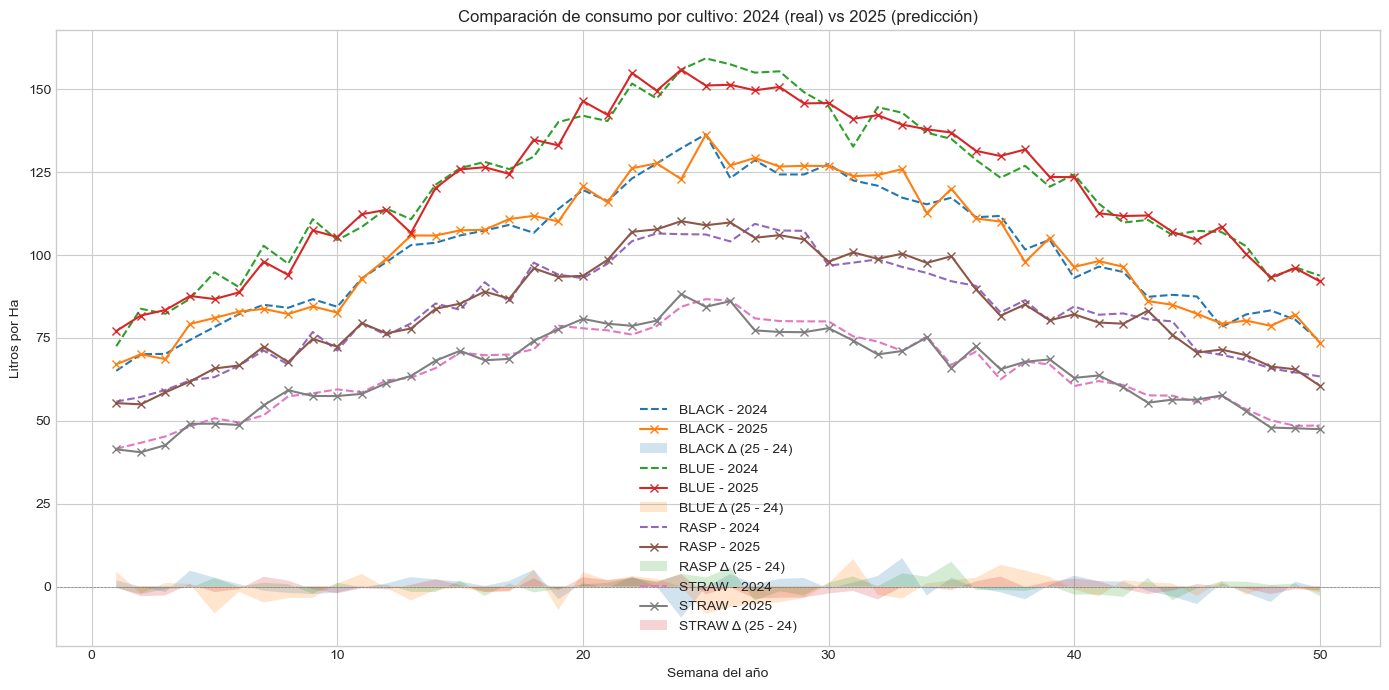

<Figure size 640x480 with 0 Axes>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos reales 2024
df_2024 = pd.read_csv("base_fake.csv")
df_2024["Año"] = 2024

# Renombrar para unificar columna
df_2024 = df_2024.rename(columns={"Litros_usados": "Litros_estimado"})
df_2024 = df_2024[["Semana", "Cultivo", "Litros_estimado", "Año"]]

# Tomar predicción 2025
df_2025 = df_final[df_final["Año"] == 2025][["Semana", "Cultivo", "Litros_estimado", "Año"]]

# Combinar en un solo DataFrame
df_comparacion = pd.concat([df_2024, df_2025], ignore_index=True)

# Agrupar por Cultivo, Año, Semana
resumen = df_comparacion.groupby(["Cultivo", "Año", "Semana"]).agg({
    "Litros_estimado": "mean"
}).reset_index()

# Crear gráfico combinado por berry
berries = resumen["Cultivo"].unique()

plt.figure(figsize=(14, 7))

for berry in berries:
    df_berry = resumen[resumen["Cultivo"] == berry]
    
    df_2024 = df_berry[df_berry["Año"] == 2024].set_index("Semana")
    df_2025 = df_berry[df_berry["Año"] == 2025].set_index("Semana")
    
    # Combinar por semana
    df_merge = df_2024[["Litros_estimado"]].rename(columns={"Litros_estimado": "2024"}).join(
        df_2025[["Litros_estimado"]].rename(columns={"Litros_estimado": "2025"})
    )

    # Línea 2024 y 2025
    plt.plot(df_merge.index, df_merge["2024"], linestyle="--", label=f"{berry} - 2024")
    plt.plot(df_merge.index, df_merge["2025"], marker="x", label=f"{berry} - 2025")

    # Diferencia 2025 - 2024
    df_merge["Delta"] = df_merge["2025"] - df_merge["2024"]
    plt.fill_between(df_merge.index, 0, df_merge["Delta"],
                     alpha=0.2, label=f"{berry} Δ (25 - 24)")

plt.title("Comparación de consumo por cultivo: 2024 (real) vs 2025 (predicción)")
plt.xlabel("Semana del año")
plt.ylabel("Litros por Ha")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Guardar la imagen perfectamente para Canva
plt.savefig("grafico_driscolls_slide_final.png", dpi=300, bbox_inches="tight", transparent=True)


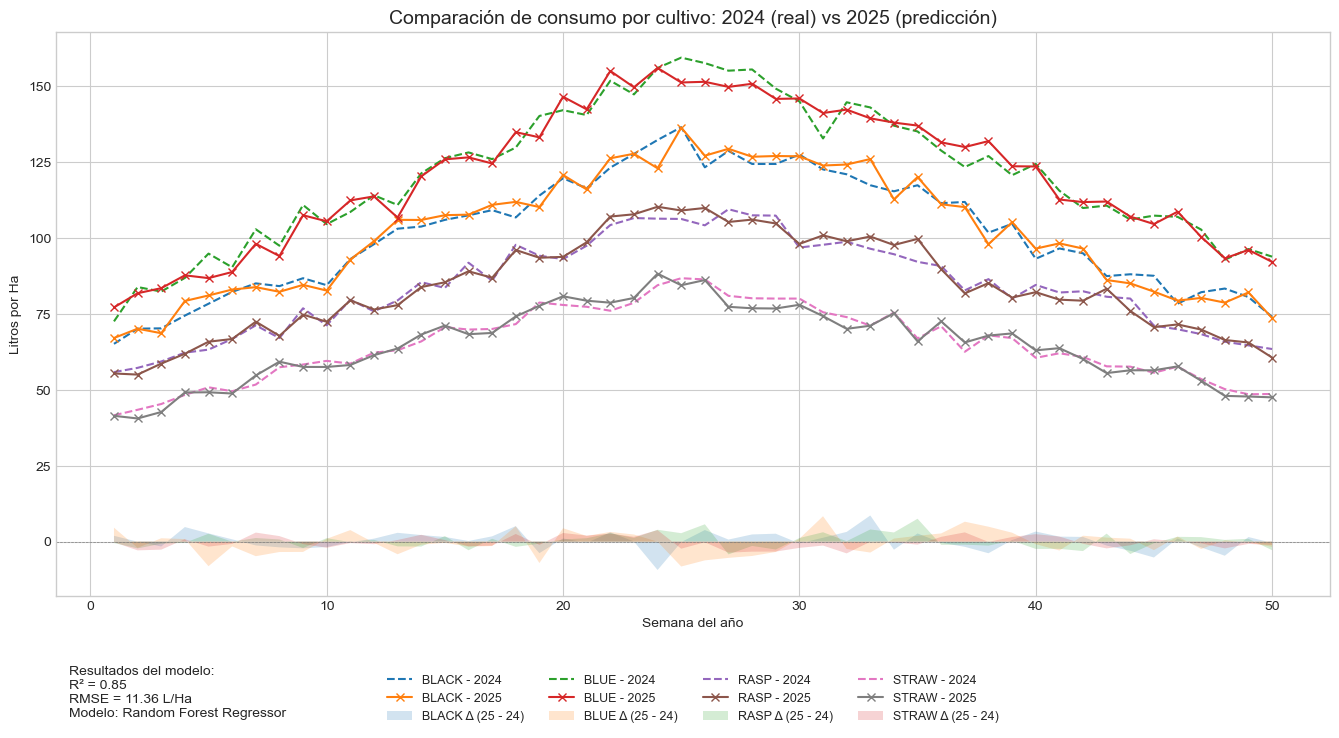

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Preparar figura con fondo transparente
fig, ax = plt.subplots(figsize=(13.5, 7.5), facecolor='none')
ax.set_facecolor('none')  # fondo del gráfico transparente

# Loop para graficar berries
for berry in resumen["Cultivo"].unique():
    df_berry = resumen[resumen["Cultivo"] == berry]
    df_2024 = df_berry[df_berry["Año"] == 2024].set_index("Semana")
    df_2025 = df_berry[df_berry["Año"] == 2025].set_index("Semana")

    df_merge = df_2024[["Litros_estimado"]].rename(columns={"Litros_estimado": "2024"}).join(
        df_2025[["Litros_estimado"]].rename(columns={"Litros_estimado": "2025"})
    )

    ax.plot(df_merge.index, df_merge["2024"], linestyle="--", label=f"{berry} - 2024")
    ax.plot(df_merge.index, df_merge["2025"], marker="x", label=f"{berry} - 2025")
    df_merge["Delta"] = df_merge["2025"] - df_merge["2024"]
    ax.fill_between(df_merge.index, 0, df_merge["Delta"], alpha=0.2, label=f"{berry} Δ (25 - 24)")

# Personalización
ax.set_title("Comparación de consumo por cultivo: 2024 (real) vs 2025 (predicción)", fontsize=14)
ax.set_xlabel("Semana del año")
ax.set_ylabel("Litros por Ha")
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=9)
ax.grid(True)

model_text = (
    "Resultados del modelo:\n"
    "R² = 0.85\n"
    "RMSE = 11.36 L/Ha\n"
    "Modelo: Random Forest Regressor"
)

# Posicionamos en coordenadas relativas (x=0.01, y=0.05)
ax.text(
    0.01, -0.22,  # x = izq, y = altura similar a leyenda
    model_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='none')
)
plt.tight_layout()

# ✅ Guardar con transparencia real (para Canva)
fig.savefig("grafico_driscolls_slide_final.png", dpi=300, bbox_inches="tight", transparent=True)

ValueError: columns overlap but no suffix specified: Index(['Cultivo', 'Año'], dtype='object')

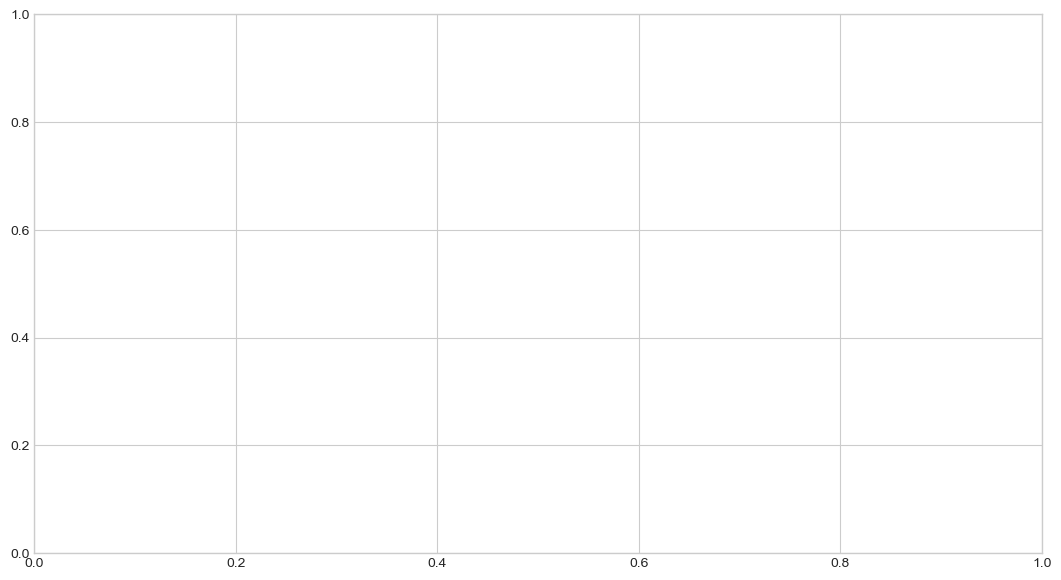

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Opcional: usar estilo limpio
plt.style.use("seaborn-v0_8-whitegrid")

# Tamaño ideal para slide 16:9 (en pulgadas)
fig, ax = plt.subplots(figsize=(13, 7))

# Repite el agrupamiento y merge como antes...
# (omitido aquí por brevedad, pero asumiendo que tienes "resumen")

for berry in resumen["Cultivo"].unique():
    df_berry = resumen[resumen["Cultivo"] == berry]
    df_2024 = df_berry[df_berry["Año"] == 2024].set_index("Semana")
    df_2025 = df_berry[df_berry["Año"] == 2025].set_index("Semana")
    
    df_merge = df_2024.rename(columns={"Litros_estimado": "2024"}).join(
        df_2025.rename(columns={"Litros_estimado": "2025"})
    )
    
    ax.plot(df_merge.index, df_merge["2024"], linestyle="--", label=f"{berry} - 2024")
    ax.plot(df_merge.index, df_merge["2025"], marker="x", label=f"{berry} - 2025")
    
    df_merge = df_2024[["Litros_estimado"]].rename(columns={"Litros_estimado": "2024"}).join(
    df_2025[["Litros_estimado"]].rename(columns={"Litros_estimado": "2025"})
    )

# Ajustes estéticos clave
ax.set_title("Comparación de consumo por cultivo: 2024 (real) vs 2025 (predicho)", fontsize=14, weight='bold')
ax.set_xlabel("Semana del año", fontsize=12)
ax.set_ylabel("Litros por Ha", fontsize=12)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=9, frameon=False)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Guardar perfectamente sin bordes blancos
plt.savefig("grafico_slide_driscolls.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()